# Import Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

Download necessary libraries

In [2]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('vader_lexicon')

# Read Data

In [3]:
train_df = pd.read_csv("../data/Twitter/twitter_training.csv",header=None)
test_df = pd.read_csv("../data/Twitter/twitter_validation.csv",header=None)
train_df.columns = ['number','topic','sentiment','tweet']
test_df.columns = ['number','topic','sentiment','tweet']

# Data Preprocessing - encode sentiment // keep only sentiment &tweet

In [4]:
def process_sentiment(df):
    df = df[df['sentiment'].isin(['Positive','Negative','Neutral'])]
    df.loc[df.sentiment=='Negative', 'sentiment'] = 0
    df.loc[df.sentiment=='Neutral', 'sentiment'] = 1
    df.loc[df.sentiment=='Positive', 'sentiment'] = 2
    df.loc[:,'sentiment']= df['sentiment'].astype(int)
    return df

In [5]:
train_df = process_sentiment(train_df)
test_df = process_sentiment(test_df)

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


drop "number" columns and drop null tweets

In [6]:
train_df = train_df[train_df.tweet.notnull()].drop('number',axis=1)
test_df = test_df[test_df.tweet.notnull()].drop('number',axis=1)

# Process Tweet Text

In [7]:
# define stopwords & Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def text_processer(text):
    text = re.sub("[^a-zA-Z]"," ",str(text)) # Keep only letters. Remove numbers & symbols
    text = text.lower().split()# convert to lower case & split words to list
    text = set([lemmatizer.lemmatize(str(x)) for x in text]) #lemmatizing
    text = " ".join([w for w in text if not w in stop_words]) #Filter stop words & Join back to str
    return text

In [11]:
train_df['cleaned_tweet'] = [text_processer(n) for n in train_df['tweet']]
test_df['cleaned_tweet'] = [text_processer(n) for n in test_df['tweet']]

In [12]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train_df['cleaned_tweet']).toarray()
test_X = tfidf.transform(test_df['cleaned_tweet']).toarray()

# Train Test Split

In [13]:
train_X,valid_X, train_Y,valid_Y = train_test_split(X,
    train_df['sentiment'], test_size=0.33,random_state=100)

In [14]:
test_Y = test_df['sentiment'].values

# Define models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [16]:
ml_models =  {
    'logres':LogisticRegression(),
    'decision_tree':DecisionTreeClassifier(),
    'random_forest':RandomForestClassifier(),
    'gaussianNB':GaussianNB(),
    'KNN':KNeighborsClassifier()
    }

# Train Models

================LogisticRegression()================


/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score: 0.8985507246376812


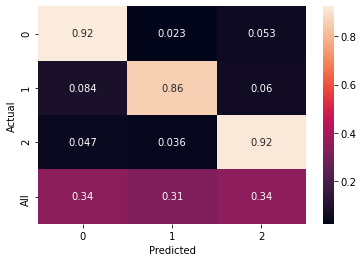

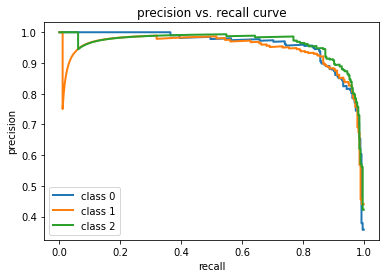

================DecisionTreeClassifier()================
Accuracy Score: 0.9082125603864735


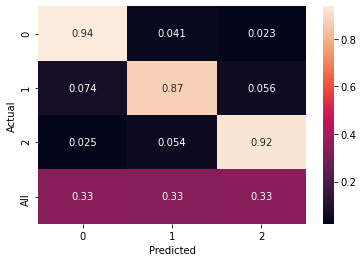

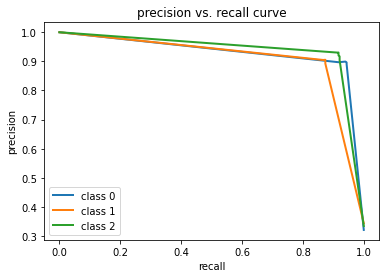

================RandomForestClassifier()================
Accuracy Score: 0.9565217391304348


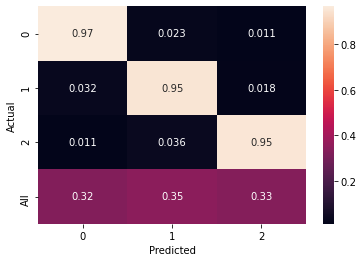

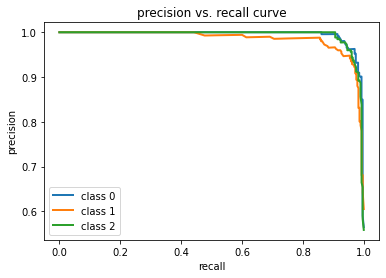

================GaussianNB()================
Accuracy Score: 0.8067632850241546


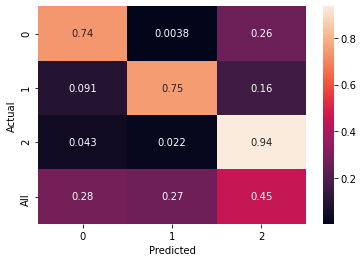

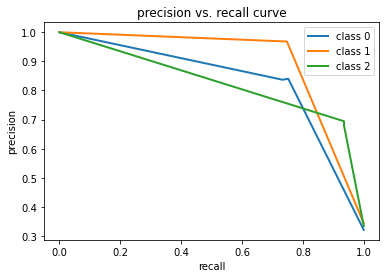

================KNeighborsClassifier()================
Accuracy Score: 0.9214975845410628


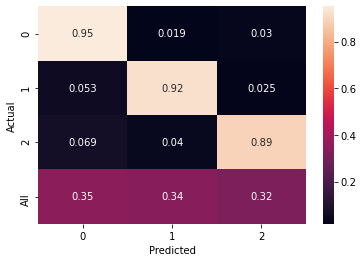

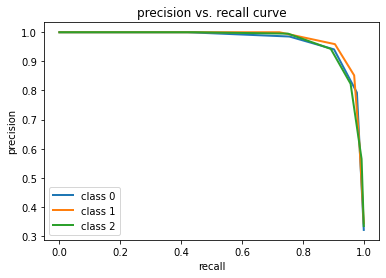

In [17]:
for model_name in ml_models:
    model = ml_models[model_name]
    print("================{}================".format(model))
    model.fit(train_X,train_Y)

    ## Accuracy score
    score = model.score(test_X,test_Y)
    print("Accuracy Score: {}".format(score))
    fct = model.predict(test_X)

    ## Confusion Matrix
    cf_matrix = pd.crosstab(test_Y,fct,rownames=['Actual'],colnames=['Predicted'],margins=True,normalize='index')
    fig,ax = plt.subplots()
    sns.heatmap(cf_matrix,annot=True,ax=ax)
    plt.show()
    plt.close()

    ## PR Curve
    fct_proba = model.predict_proba(test_X)

    test_Y_lab = pd.get_dummies(test_Y).values
    precision = dict()
    recall = dict()
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_Y_lab[:, i],
                                                            fct_proba[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()